In [2]:
# Import necessary modules
%matplotlib inline
import cvxpy as cvx
import numpy as np
from scipy import random
from scipy import linalg
import matplotlib.pyplot as plt

In [3]:
def generate_points(num, dim):
    return np.matrix(4 * np.random.random((num, dim)) - 2)

In [4]:
def sum_elem_product(A,B):
    return cvx.sum_entries(cvx.mul_elemwise(A, B))

In [5]:
def generate_ss_distances(sensors):
    return list(map(lambda s1: 
                list(map(lambda s2: np.linalg.norm(s1 - s2), sensors))
            , sensors))

def generate_sa_distances(sensors, anchors):
    return list(map(lambda s: 
                list(map(lambda a: np.linalg.norm(a - s), anchors))
            , sensors))

In [5]:
def get_SOCP_result(sensors, anchors):
    d_ss = generate_ss_distances(sensors)
    d_sa = generate_sa_distances(sensors, anchors)
    
    x = cvx.Variable(num_sensors, dim)
    objective = cvx.Minimize(0)
    
    constraints  = []
    for i in range(num_sensors):
        x_i = x[i, :]
        for j in range(num_anchors):
            constraints.append(cvx.norm(x_i - anchors[j]) <= d_sa[i][j])
        for j in range(num_sensors):
            if i < j:
                constraints.append(cvx.norm(x_i - sensors[j]) <= d_ss[i][j])

    prob = cvx.Problem(objective, constraints)
    result = prob.solve(solver = 'MOSEK')
    print("SOCP complete")
    return x.value

In [6]:
def get_SDP_result(sensors, anchors):    
    
    A = enforce_id(sensors)
    B = enforce_id2(sensors)
    C = sensor_constraints(sensors)
    D = anchor_constraints(sensors, anchors)

    Z = cvx.Semidef(num_sensors + dim)
    
    constraints = []
    for id_constraint, rhs in zip(A[0], A[1]):
        constraints.append(sum_elem_product(id_constraint, Z) == rhs)
    for id_constraint2, rhs in zip(B[0], B[1]):
        constraints.append(sum_elem_product(id_constraint2, Z) == rhs)
    for sensor_constraint, rhs in zip(C[0], C[1]):
        constraints.append(sum_elem_product(sensor_constraint, Z) == rhs)
    for anchor_constraint, rhs in zip(D[0], D[1]):
        constraints.append(sum_elem_product(anchor_constraint, Z) == rhs)
        
    objective = cvx.Minimize(0)
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(solver = 'MOSEK')

    print("SDP complete")
    return np.transpose(Z[0:dim, dim:dim+num_sensors].value)

#Make first set of constraint matrices (look like identity)
def enforce_id(sensors):
    dim = np.shape(sensors)[1]
    num_sensors = np.shape(sensors)[0]
    matrices = []
    rhs = []
    for i in range(dim):
        new_matrix = np.zeros((dim+num_sensors, dim+num_sensors))
        new_matrix[i,i] = 1
        matrices.append(new_matrix)
        rhs.append(1)
        
    return (matrices, rhs)

#Make second set of constraint matrices (symmetric holders) 
def enforce_id2(sensors):
    dim = np.shape(sensors)[1]
    num_sensors = np.shape(sensors)[0]
    matrices = []
    rhs = []
    for i in range(dim):
        for j in range(dim):
            new_matrix = np.identity(dim)
            if(j > i):
                new_matrix[i,j] = 1
                new_matrix[j,i] = 1
                big_matrix = np.zeros((dim+num_sensors, dim+num_sensors))
                big_matrix[0:dim,0:dim] = new_matrix
                matrices.append(big_matrix)
                rhs.append(dim)
                
    return (matrices, rhs)


#Make third set of constraint matrices (anchors to sensors)
def sensor_constraints(sensors):
    dim = np.shape(sensors)[1]
    num_sensors = np.shape(sensors)[0]
    d_ss = generate_ss_distances(sensors)
    matrices = []
    rhs = []
    zero_vec_dim = np.zeros(dim)
    for i in range(num_sensors):
        for j in range(i+1, num_sensors):
            zero_vec_num_s = np.zeros(num_sensors)
            zero_vec_num_s[i] = 1
            zero_vec_num_s[j] = -1
            
            new_vec = np.matrix(np.append(zero_vec_dim, zero_vec_num_s))
            
            new_matrix = np.dot(np.transpose(new_vec), new_vec)
            
            matrices.append(new_matrix)
            rhs.append(d_ss[i][j]**2)

    return (matrices, rhs)

#Make fourth set of constraint matrices (sensors to sensors)
def anchor_constraints(sensors, anchors):
    num_anchors = np.shape(anchors)[0]
    d_sa = generate_sa_distances(sensors, anchors)
    matrices = []
    rhs = []
    for i in range(num_anchors):
        for j in range(num_sensors):
            zero_vec_num_s = np.zeros(num_sensors)
            zero_vec_num_s[j] = -1

            new_vec = np.append(np.array(anchors[i,:]), np.array(zero_vec_num_s))
            new_vec = np.matrix(new_vec)
            new_matrix = np.dot(np.transpose(new_vec), new_vec)
            matrices.append(new_matrix)
            rhs.append(d_sa[j][i]**2)

    return (matrices, rhs)

In [18]:
def get_NLLS_matches(sensors, anchors):
    check = 1000
    max_iter = 10000
    k = 0

    # Initial sensors guess
    sensors_0 = generate_points(num_sensors, dim)
    sensors_k = sensors_0

    # iteration
    alpha = .0000001
    while check > 10**-8 and k < max_iter:
        sensors_k1 = sensors_k - alpha * grad(sensors_k)
        check = np.linalg.norm(sensors_k1 - sensors_k)
        sensors_k = sensors_k1
        if(k % 2000 == 0):
            print("NLLS k:" + str(k))
        k = k+1

    print("NLLS complete")
    return sensors_k
    
def grad(X):
    sensor_distance_sum = np.zeros((1,X.shape[1]))
    anchor_distance_sum = np.zeros((1,X.shape[1]))
    gradient = np.zeros(X.shape)

    for i, sensor_i in enumerate(X):
        for j, sensor_j in enumerate(X):
            if(i != j):
                sensor_distance_sum += (np.linalg.norm(sensor_i - sensor_j)**2 - \
                                        np.linalg.norm(sensors[i,:] - sensors[j,:])**2) * \
                                       (sensor_i - sensor_j)

        for k, anchor_k in enumerate(anchors):
            anchor_distance_sum += (np.linalg.norm(anchor_k - sensor_i)**2 - \
                                    np.linalg.norm(anchors[k,:] - sensors[i,:])**2) * \
                                   (sensor_i - anchor_k)

        gradient[i,:] = 8*sensor_distance_sum + 4*anchor_distance_sum

    return gradient

In [8]:
def get_sensor_matches(sensors, results):
    matches = []
    for sensor, result in zip(sensors, results):
        matches.append(np.linalg.norm(sensor - result) < 10**(-6))
    return np.array(matches)

In [9]:
#run simulation
dim = 2
num_sensors = 10
num_anchors = 4

anchors = generate_points(num_anchors, dim)
sensors = generate_points(num_sensors, dim)

SOCP_result = get_SOCP_result(sensors, anchors)
SDP_result = get_SDP_result(sensors, anchors)
NLLS_result = get_NLLS_matches(sensors, anchors)

SOCP complete
SDP complete
NLLS k:0
NLLS k:2000
NLLS k:4000
NLLS k:6000
NLLS k:8000
NLLS complete


In [10]:
def plot_results(anchors, sensors, results):
    anchor_x = np.array(anchors[:,0])
    anchor_y = np.array(anchors[:,1])
    
    matches = get_sensor_matches(sensors,results)
    
    matched_sensors_x = np.array(sensors[matches,0])
    matched_sensors_y = np.array(sensors[matches,1])
    unmatched_sensors_x = np.array(sensors[~matches,0])
    unmatched_sensors_y = np.array(sensors[~matches,1])
    
    fig, out_plot = plt.subplots()
    
    out_plot.scatter(x=anchor_x, y=anchor_y, c="g", alpha=0.5)
    out_plot.scatter(x=matched_sensors_x, y=matched_sensors_y, c="b", alpha=0.5)
    out_plot.scatter(x=unmatched_sensors_x, y=unmatched_sensors_y, c="r", alpha=0.5)

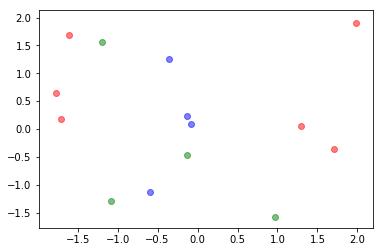

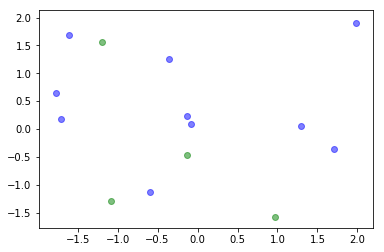

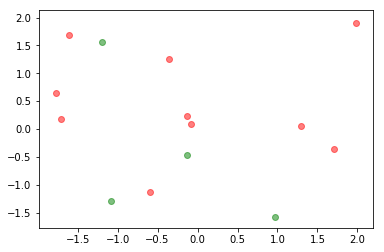

In [11]:
plot_results(anchors, sensors, SOCP_result)
plot_results(anchors, sensors, SDP_result)
plot_results(anchors, sensors, NLLS_result)

## Question 2 - SNL with Noise

In the event that the sensor readings are noisy, it is useful to introduce a corresponding representation of the noise to our objective function and attempt to minimize it. This makes the process slightly more robust. We find that the SDP relaxation automatically sets the noise to zero, leading the optimal solution.  

In [33]:
num_sensors = 10
num_anchors = 4
dim = 2

Z = cvx.Semidef(num_sensors + dim)
anchors = generate_points(num_anchors, dim)
sensors = generate_points(num_sensors, dim)

In [34]:
# order of indexing: (1,2), (1,3), (1,4)... (9,10)
delta_p_ss = cvx.Variable((int) (num_sensors*(num_sensors-1)/2))
delta_pp_ss = cvx.Variable((int) (num_sensors*(num_sensors-1)/2))
                           
# order of indexing: (anchor, sensor), primary sort on anchors
delta_p_sa = cvx.Variable(num_anchors * num_sensors)
delta_pp_sa = cvx.Variable(num_anchors * num_sensors)

In [35]:
constraints = []

A = enforce_id(sensors)
B = enforce_id2(sensors)
C = sensor_constraints(sensors)
D = anchor_constraints(sensors, anchors)

constraints.append(delta_p_ss >= 0)
constraints.append(delta_pp_ss >= 0)
constraints.append(delta_p_sa >= 0)
constraints.append(delta_pp_sa >= 0)

# add the noise through the presence of dp and dpp
for id_constraint, rhs in zip(A[0], A[1]):
    constraints.append(sum_elem_product(id_constraint, Z) == rhs)
for id_constraint2, rhs in zip(B[0], B[1]):
    constraints.append(sum_elem_product(id_constraint2, Z) == rhs)
for sensor_constraint, rhs, dp, dpp in zip(C[0], C[1], delta_p_ss, delta_pp_ss):
    constraints.append(sum_elem_product(sensor_constraint, Z) + \
                       dp - dpp == rhs)
for anchor_constraint, rhs, dp, dpp in zip(D[0], D[1], delta_p_sa, delta_pp_sa):
    constraints.append(sum_elem_product(anchor_constraint, Z) + \
                       dp - dpp == rhs)


In [36]:
objective = cvx.Minimize(cvx.sum_entries(delta_p_ss) + \
                         cvx.sum_entries(delta_pp_ss) + \
                         cvx.sum_entries(delta_p_sa) + \
                         cvx.sum_entries(delta_pp_sa))

# First find some solution given the presence of the noise terms
prob = cvx.Problem(objective, constraints)
result = prob.solve(solver = 'MOSEK')

In [37]:
print("Real sensors: ")
print(sensors)
print("Generated Sensors: ")
generated = np.transpose(Z[0:dim, dim:dim+num_sensors].value)
print(generated)

Real sensors: 
[[ 0.46409552  1.63450733]
 [ 1.72346984  1.14498925]
 [-1.23989958 -1.69847233]
 [ 1.27919014  0.07435849]
 [ 1.08567831 -1.92857085]
 [ 0.81242805  1.2767817 ]
 [ 0.09832017  1.37298782]
 [ 0.83427247  0.54403558]
 [ 0.01516241 -0.04764979]
 [-0.25331007  0.35229282]]
Generated Sensors: 
[[ 0.46409555  1.63450726]
 [ 1.72346966  1.14498936]
 [-1.23989952 -1.69847233]
 [ 1.27918996  0.07435863]
 [ 1.08567805 -1.92857057]
 [ 0.81242801  1.27678169]
 [ 0.09832024  1.37298773]
 [ 0.83427238  0.54403563]
 [ 0.01516241 -0.04764978]
 [-0.25331001  0.35229276]]


In [27]:
# Now use generate sensor locations as the initial points for the 
# nonlinear least squares approach. 
check = 1000
max_iter = 10000
k = 0

# Initial sensors guess
sensors_0 = generated
sensors_k = sensors_0

# D iteration
alpha = .000001
while check > 10**-8 and k < max_iter:
    sensors_k1 = sensors_k - alpha * grad(sensors_k)
    check = np.linalg.norm(sensors_k1 - sensors_k)
    sensors_k = sensors_k1
    k = k+1
    
print("Real sensors: ")
print(sensors)
print("Generated Sensors: ")
print(sensors_k)

Real sensors: 
[[ 0.86109148  0.98948059]
 [ 1.60656185 -0.48360963]
 [ 1.0531452  -0.62324633]
 [-1.22598159 -0.48773091]
 [ 0.70269259 -1.78430939]
 [-0.71866919  1.51265894]
 [ 0.31691533  1.49150015]
 [ 1.15777625  1.46704818]
 [ 0.76394984  0.90913851]
 [-0.43071197 -0.15019594]]
Generated Sensors: 
[[ 0.86109148  0.98948059]
 [ 1.60656184 -0.48360962]
 [ 1.05314519 -0.62324632]
 [-1.22598158 -0.4877309 ]
 [ 0.70269257 -1.78430938]
 [-0.7186692   1.51265893]
 [ 0.31691533  1.49150015]
 [ 1.15777624  1.46704818]
 [ 0.76394983  0.9091385 ]
 [-0.43071197 -0.15019594]]
